### Afazeres:
- Refazer o método para gerar um dataset de imagens

***

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("C:\\Users\\olipp\\Documents\\GitHub\\tutorials\Plotting")

In [14]:
from Project import Project
from Scripts.Imaging import Imaging

import torch
import torch.nn as nn
import pandas as pd

from PlottingFunctions import *

***

__Tsinghua Dataset__

In [ ]:
from Scripts.data.TsinghuaDataset import TsinghuaDataset
from Scripts.data.Dataloader import Dataloader

In [53]:
BATCH_SIZE = 64
SIGNAL_LENGTH = 250
# NUM_SUBJECTS = 5 + 1
NUM_CLASSES = 2

# individuals = [*map(lambda k: str(k), [*range(1, NUM_SUBJECTS + 1)])]
# individuals.remove('5')

classes = list(range(1, NUM_CLASSES + 1))
dataset = TsinghuaDataset('benchmark', Project, SIGNAL_LENGTH, classes = classes)
dataloaders, _ = Dataloader(dataset, BATCH_SIZE)

In [54]:
sample = next(iter(dataloaders['train']))[0].numpy()[0][0][0].reshape(1, -1)

In [56]:
ImagingInterface = Imaging(plot = False)

__Unicamp Dataset__

In [74]:
from Scripts.UnicampSSVEPDataset import SSVEPDataset
from Scripts.UnicampSSVEPDataloader import SSVEPDataloader

SIGNAL_LENGTH = '512'
preprocessing = 'CCA'
data_info = pd.read_csv((Project.output/('SSVEPDataset_'+SIGNAL_LENGTH+'.csv')).__str__(), dtype = 'str')
dataset = SSVEPDataset(Project, preprocessing, data_info, SIGNAL_LENGTH)

batch_size = 32
dataloaders, dataset_sizes = SSVEPDataloader(dataset, batch_size, validation_split = .4)

In [81]:
sample = next(iter(dataloaders['train']))[0].numpy()[0][0]

***

### Gramian Angular Field Script

#### Description

The original time series $X = \{x_1,\; x_2, \; \ldots, \; x_n\}$ is first normalized between $[-1,\; 1]$ by:

$$
\begin{eqnarray}
    \label{eq:gaf_normalization}
    \tilde{x}_{i} = \dfrac{(x_i - X_{\text{max}}) + (x_i - X_{\text{min}})}{X_{\text{max}} - X_{\text{min}}}
\end{eqnarray}
$$

The rescaled time series $\tilde{X}$ can then be represented in polar coordinates by encoding its values using the angular cosine function and the time stamp $t_i$, which is divided by a constant factor $N$ in order to regularize the span of the coordinate system. 

$$
\begin{eqnarray}
    \label{eq:gaf_polar_transformation}
    \begin{cases}
        \phi_i = \arccos{(\overline{x}_i)}, & -1 \leq \tilde{x}_i \leq 1, \;\; \tilde{x}_i \in \tilde{X} \\
        r_i = \dfrac{t_i}{N}, & t_i \in \mathbb{N}
    \end{cases}
\end{eqnarray}
$$

With this change of coordinates, we build two quasi-Gramian matrices, the Gramian Angular Fields (GAFs): the Gramian Summation Angular Field (GASF) and the Gramian Difference Angular Field (GADF). Both matrices preserve temporal dependency and encode temporal correlations of superposition and difference, the main diagonal corresponding to the original time series. The size of each matrix will be equal to $n \times n$, hence Piecewise Aggregation Approximation (PAA) is applied to short the time series while preserving trends.

$$
\begin{eqnarray}
    \label{eq:gaf_gasf}
    GASF = 			
    \begin{bmatrix}
        \cos(\phi_1 + \phi_1) & \cdots & \cos(\phi_1 + \phi_n) \\
        \cos(\phi_2 + \phi_1) & \cdots &
\cos(\phi_2 + \phi_n) \\
        \vdots & \ddots & \vdots \\
        \cos(\phi_n + \phi_1) & \cdots & \cos(\phi_n + \phi_n) \\
    \end{bmatrix} \\
    GASF = \tilde{X}^{T}\cdot\tilde{X} - \sqrt{I - \tilde{X}^2}^{T}\cdot\sqrt{I - \tilde{X}^2} \\
    GADF = 			
    \begin{bmatrix}
        \sin(\phi_1 - \phi_1) & \cdots & \sin(\phi_1 - \phi_n) \\
        \sin(\phi_2 - \phi_1) & \cdots &
\sin(\phi_2 - \phi_n) \\
        \vdots & \ddots & \vdots \\
        \sin(\phi_n - \phi_1) & \cdots & \sin(\phi_n - \phi_n) \\
    \end{bmatrix} \\
    GADF = \sqrt{I - \tilde{X}^2}^{T} \cdot \tilde{X} - \tilde{X}^{T}\cdot \sqrt{I - \tilde{X}^2}
\end{eqnarray}
$$

### Markov Transition Field Script

#### Description

Inspired by previous works that try to codify time series into a network structures (citação), the Markov Transition Field (MTF) explores Markov transition probabilities while maintaing information in the time domain. A time series $X = \{x_1,\; x_2, \; \ldots, \; x_n\}$ has its data (magnitude) divided into $Q$ quantile bins and each value $x_i$ is assigned to a corresponding bin $q_j \; (j \in [1, Q])$. The Markov Transition Matrix $W = (w_{i, j})_{Q\times Q}$ is then built, where a value $w_{i, j}$ is given by the frequency with which there is a transition between quantiles $q_i$ and $q_j$, satisfying $\sum_j w_{ij} = 1$. The Markov Transition Field is defined by

$$
\begin{eqnarray}
    M = 
    \begin{bmatrix}
        w_{ij}|_{x_1 \in q_i,\; x_1 \in q_j} & \cdots & w_{ij}|_{x_1 \in q_i, \; x_n \in q_j} \\
        w_{ij}|_{x_2 \in q_i,\; x_1 \in q_j} & \cdots & w_{ij}|_{x_2 \in q_i, \; x_n \in q_j} \\
        \vdots & \ddots & \vdots \\
        w_{ij}|_{x_n \in q_i,\; x_1 \in q_j} & \cdots & w_{ij}|_{x_n \in q_i, \; x_n \in q_j} \\
    \end{bmatrix}
\end{eqnarray}
$$


Each value $M_{ij}$ corresponds to the transition probability $q_i \rightarrow q_j$, where $q_i, q_j \in [1, Q]$ are the quantile bins that contain the data at time stamp $i$ and $j$, respectively. It can be understood as a spreading out of the Markov Transition Matrix $W$, considering temporal relations - $M_{i, j | |i - j| = k}$ denotes the transition probability between points with time interval $k$. The size of the MTF is regulated by the non-overlapping application of a $m \times m $ kernel $\{\dfrac{1}{m^2}\}_{m\times m}$.  

### Recurrence Plot Script

#### Description

The Recurrence Plot is a graphical tool for measuring the time constancy of dynamical systems (citação). Through this diagnostic tool it's possible to infer properties of the underlying system of a time series that otherwise would be difficult to obtain, such as autonomy.

Given a time series $x(1), \ldots, x(n)$, and considering $i \in \{1, \ldots, n-d+1\}$, we choose an embedding dimension $d$, building a d-dimensional orbit $y(i)$ given by

$$
\begin{eqnarray}
    \label{eq:recurr_orbit}
    y(i) = (x(i), x(i+1), \ldots, x(i+d-1)) 
\end{eqnarray}
$$

The plot is built by a set of points $R_{i, j}$ defined by

$$
\begin{eqnarray}
    \label{eq:recurr_plot_eq}
    R_{i, j} = \Theta( \varepsilon_i - ||y(i) - y(j)||)
\end{eqnarray}
$$

where $\Theta(\cdot)$ is the Heaviside function, a stepsize function 1 or 0 if its argument is non-negative or positive, respectively, and $\varepsilon_i$ is a threshold. The threshold needs to be chosen such that a reasonable number of points $y(j)$ lies within its radius centered at $y(i)$, therefore it can depend on $i$.

#### What set of parameters would be optimum to classify SSVEP signals?

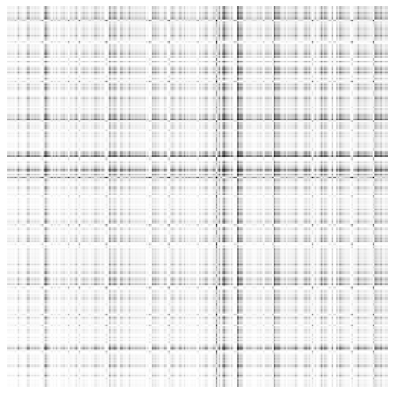

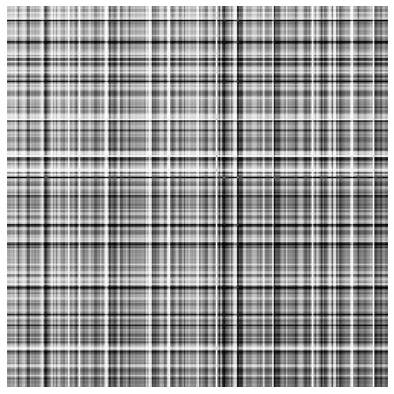

In [7]:
# Difference
gadf_result = ImagingInterface.apply('gadf', sample)

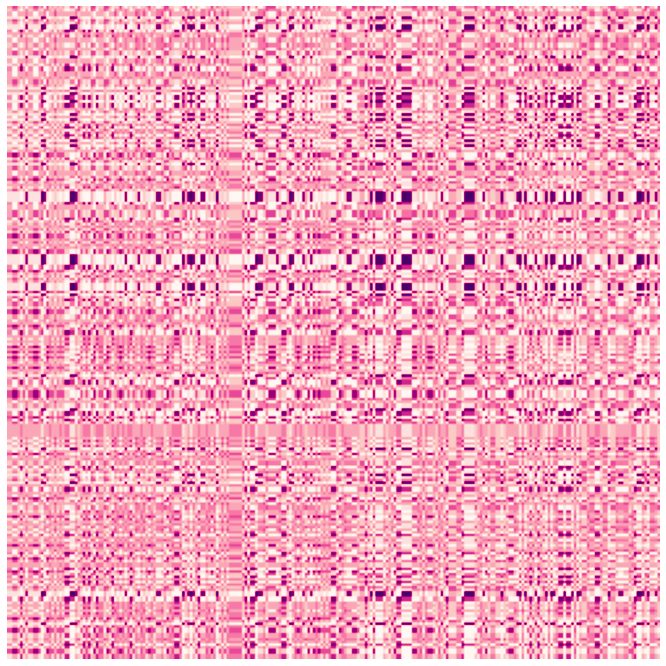

In [17]:
# Summation
ImagingInterface.pic_args = {'figsize': (12, 12), 'cmap': 'RdPu'} 
mtf_result = ImagingInterface.apply('mtf', sample)

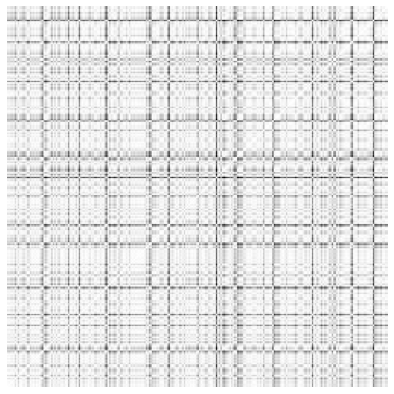

In [24]:
# Summation
ImagingInterface.pic_args = None
rp_result = ImagingInterface.apply('rp', sample, percentage = 1)

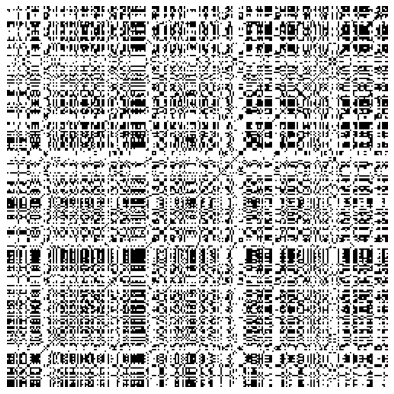

In [40]:
# Summation
ImagingInterface.pic_args = None
rp_result = ImagingInterface.apply('rp', sample, threshold = 'distance', percentage = 10)

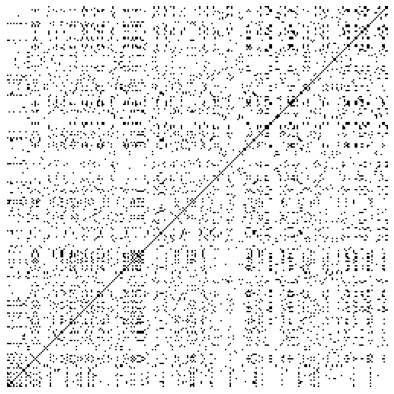

In [41]:
# Summation
ImagingInterface.pic_args = None
rp_result = ImagingInterface.apply('rp', sample, threshold = 'point', percentage = 10)

In [47]:
axs.flatten()

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

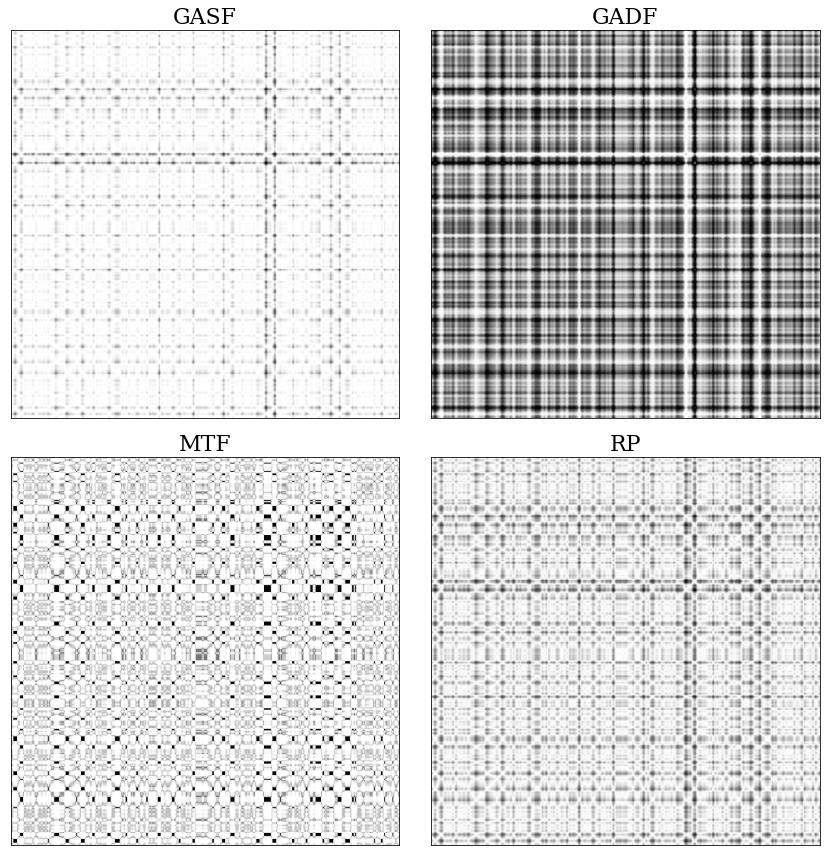

In [83]:
fig, axs = grid_frames(num_rows = 2, num_cols = 2, size = (15, 15), spacing = (0.1, 0.01), remove_all_axis = True, axs_titles = ['GASF', 'GADF', 'MTF', 'RP'],
                      ax_title_size = 22)
gasf_result = ImagingInterface.apply('gasf', sample)
axs[0][0].imshow(gasf_result[0], cmap = 'Greys', origin = 'lower')

gadf_result = ImagingInterface.apply('gadf', sample)
axs[0][1].imshow(gadf_result[0], cmap = 'Greys', origin = 'lower')

mtf_result = ImagingInterface.apply('mtf', sample)
axs[1][0].imshow(mtf_result[0], cmap = 'Greys', origin = 'lower')

rp_result = ImagingInterface.apply('rp', sample, percentage = 1)
axs[1][1].imshow(rp_result[0], cmap = 'Greys', origin = 'lower')

Faça aqui um plot em grade com todos os métodos

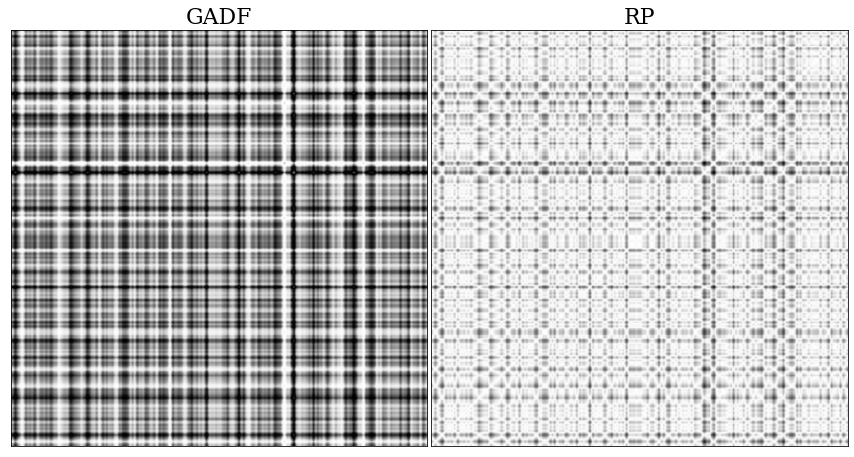

In [89]:
fig, axs = grid_frames(num_rows = 1, num_cols = 2, size = (15, 8), spacing = (0.1, 0.01), remove_all_axis = True, axs_titles = ['GADF','RP'],
                      ax_title_size = 22)

gadf_result = ImagingInterface.apply('gadf', sample)
axs[0].imshow(gadf_result[0], cmap = 'Greys', origin = 'lower')

rp_result = ImagingInterface.apply('rp', sample, percentage = 5)
axs[1].imshow(rp_result[0], cmap = 'Greys', origin = 'lower')

fig.savefig('Outputs/gadf_rp.png', bbox_inches = 'tight')

Faça aqui um plot em grade do método RP com vários parâmetros diferentes.

In [95]:
import pickle
shallow_stats = pickle.load( open( "Outputs/shallow_stats.p", "rb" ) )
deep_stats    = pickle.load( open( "Outputs/deep_stats.p", 'rb'))
plt.style.use('ggplot')

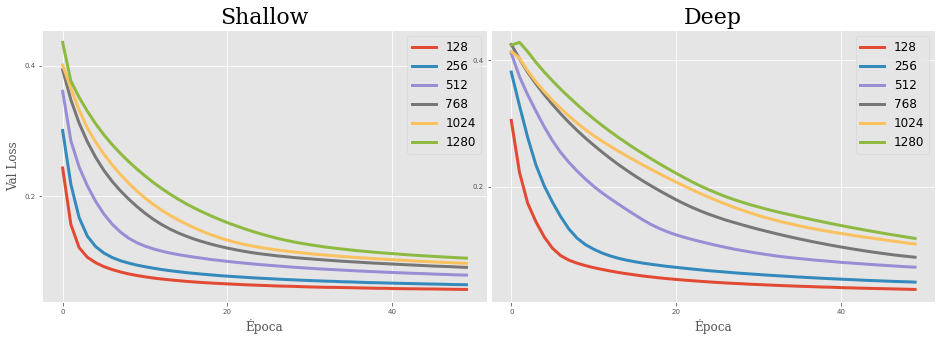

In [128]:

fig, axs = grid_frames(num_rows = 1, num_cols = 2, size = (16, 5), spacing = (0.1, 0.01), axs_titles = ['Shallow','Deep'], ax_title_size = 22, 
                       x_names = ['Época', 'Época'], y_names = ['Val Loss', ''])


signal_windows = ['128', '256', '512', '768', '1024', '1280']

for s in signal_windows:
    axs[0].plot(range(50), shallow_stats[s]['Validation Loss'], label = s, linewidth = 3)
    axs[1].plot(range(50), deep_stats[s]['Validation Loss'], label = s, linewidth = 3)
    

axs[0].legend(fontsize = 12)
axs[1].legend(fontsize = 12)

fig.savefig('Outputs/autoencoder_val_stats.png', bbox_inches = 'tight')